# Set up Libraries / GPU Check

In [1]:
######################################################Initial Packages########################################################
#Basic Operating System Stuff
import os, gc, random

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Scikit learn
import sklearn as sk  #scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts #train test split
from sklearn.metrics import confusion_matrix, roc_curve, classification_report #for 2-class model
from sklearn.preprocessing import MinMaxScaler as MMS

#Tensorflow
import tensorflow as tf 
from tensorflow.python.client import device_lib #GPU Check
import tensorflow.keras #keras
from tensorflow.keras import layers 
from tensorflow.keras import Sequential,Input,Model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Add, Activation, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #use for early stopping and reduction on level-out
from tensorflow.keras.initializers import glorot_uniform, he_uniform #to initialize random weights for filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16 
import tensorflow.keras.backend as K #let's write our own metrics and loss functions

#Graphing
import cv2
import matplotlib.pyplot as plt

print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?
################################################conda ##############################################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14734315435564514486
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4592843649959351842
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6918604064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10223603604992850650
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Super, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9911743357161371525
physical_device_desc: "device: XLA_GPU device"
]


# GPU / Memory Management

In [2]:
#Define function for clearing GPU memory
def reset_keras():
    tensorflow.keras.backend.clear_session
    gc.collect()
reset_keras()

# Read Data

## Read Function for Training Data

In [3]:
random.seed(1234) #set the random seed
images,labels=[], []  #storage for images and labels from the tensorflow files
size=224 #image size

#The data are saved as tensors and must be read that way.
#We initialize a dictionary for storing the data.
features = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

#Read the data
def readFile(files):
    mydata = tf.data.TFRecordDataset(files,num_parallel_reads=4).shuffle(buffer_size=10000).cache()
    mydata = mydata.map(lambda x: tf.io.parse_example(x, features), num_parallel_calls=4)
    for image_features in mydata:
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(size,size))
        image=cv2.merge([image,image,image])        
        images.append(image)
        labels.append(image_features['label'].numpy())

## Read Training Data from Tensors

In [4]:
reset_keras()
#make a vector of directory / file 
files=['D:/breast/training10_0/training10_0.tfrecords',
          'D:/breast/training10_1/training10_1.tfrecords',
          'D:/breast/training10_2/training10_2.tfrecords',
          'D:/breast/training10_3/training10_3.tfrecords',
          'D:/breast/training10_4/training10_4.tfrecords'
          ]
#load the data
for file in files:
    readFile(file)

## Verify Input Distribution

In [5]:
#Get counts of BI-Rads classification
print(np.bincount(labels)/len(labels))

[0.86957144 0.03763085 0.03419522 0.02617876 0.03242373]


## Refine Training Image Data

In [6]:
# Initialize min-max scaler
myscaler=MMS()

#set up the training array images and labels
x_train=np.array(images)
del images
y_train=np.array(labels)
del labels
y_train=np.where(y_train==0, 0, y_train)
y_train=np.where(y_train!=0, 1, y_train)

sizeit=[]  #array for image resizing

for i in np.arange(x_train.shape[0]):
    mytemp=np.reshape(x_train[i,:,:,0],(size,size)) #reshape to matrix
    mytemp=myscaler.fit_transform(mytemp) #scale to 0, 1
    mytemp=mytemp.reshape((size,size)) #reshape back to original size
    mytemp = np.stack((mytemp,)*3, axis=-1) #make RGB for VGG16
    sizeit.append(mytemp) #append

x_train=np.asarray(sizeit)
del sizeit #Clean up
reset_keras()

# Verify Images and Image Range

[0.86957144 0.13042856]
0.0
1.0000000000000002


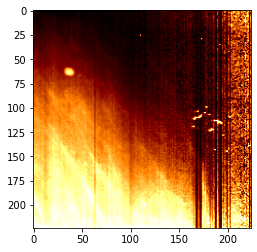

In [7]:
print(np.bincount(y_train)/len(y_train))
print(np.min(x_train[2,:,:,2]))
print(np.max(x_train[2,:,:,2]))
plt.imshow(x_train[2,:,:,2], cmap='afmhot')

## Cleanup

In [10]:
reset_keras()

## Read Test

In [11]:
#Per instructions, we need to combine both the val and test sets due to a parsing error during creation
x_test=np.concatenate((np.load("d:/breast/cv10_data/cv10_data.npy"),np.load("d:/breast/test10_data/test10_data.npy")))        
y_test=np.concatenate((np.load("d:/breast/cv10_labels.npy"),np.load("d:/breast/test10_labels.npy")))
                      
y_test=np.where(y_test==0, 0, y_test)
y_test=np.where(y_test!=0, 1, y_test)

sizeit=[]  #array for image resizing

#image resizing
for i in np.arange(x_test.shape[0]):
    mytemp=np.reshape(x_test[i,:,:,0],(299,299)) #reshape to 299 x 299
    mytemp=myscaler.fit_transform(mytemp) #scale to 0, 1
    mytemp=mytemp.reshape((299,299)) #reshape back
    mytemp=cv2.resize(mytemp,(size,size))#resize the image
    mytemp = np.stack((mytemp,)*3, axis=-1)
    sizeit.append(mytemp)
        
x_test=np.asarray(sizeit)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(55885, 224, 224, 3) (55885,) (15364, 224, 224, 3) (15364,)


## Verify Images and Sizing

1.0

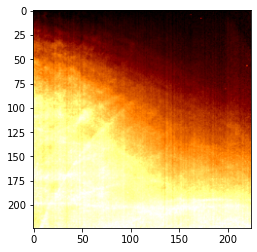

In [12]:
plt.imshow(x_test[5,:,:,0], cmap='afmhot')
np.max(x_test[8,:,:,2])

# Plot Some Images

0

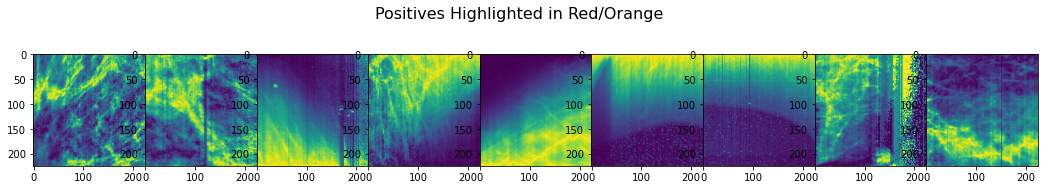

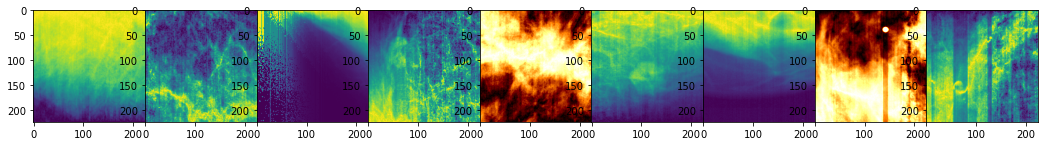

In [13]:
reset_keras() #clear memory
fig, ax = plt.subplots(1,9, figsize=[18, 3])  #set first figure
fig2, ax2 = plt.subplots(1,9, figsize=[18, 3]) #set second figure
fig.suptitle('Positives Highlighted in Red/Orange', fontsize=16)
for i in range(9):
    ax[i].imshow(x_train[i, :,:,0]) if y_train[i]==0 else ax[i].imshow(x_train[i, :,:,0],'afmhot') 
    fig.subplots_adjust(wspace=0, hspace=0)
for i in range(9):
    ax2[i].imshow(x_train[i+9, :,:,0]) if y_train[i+9]==0 else ax2[i].imshow(x_train[i+9,:,:,0],'afmhot') 
    fig2.subplots_adjust(wspace=0, hspace=0)

gc.collect()

## Autoencoder-Backup

from tensorflow.keras.optimizers import Adam

#build a sequential autoencoder as a neural network

autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu',input_shape=(55885,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
trained_model = autoencoder.fit(x_train, x_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test,x_test))

#build the encoder model
encoder=Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

#encode the data
encoded_data = encoder.predict(x_train)  # bottleneck representation

#reconstruct the data
decoded_output = autoencoder.predict(x_train)       

encoding_dim = 10
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-4](encoded_input)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)

decoder = Model(encoded_input, decoder)

# Build and Run Models

## Build Model

In [14]:
#Begin with a typical VGG16
myconv = VGG16(weights='imagenet', include_top=False, input_shape = (size,size, 3))

#Potentially fix layers.  I don't.
#for layer in myconv.layers[:-8]:
#    layer.trainable = False

#Build the rest of the model
x = myconv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid", name='classifier')(x)
model=Model(myconv.input, x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Run Model

In [15]:
reset_keras()
batch=64
numepochs=50 #may stop and re-run
model.load_weights('d:/breast/best_model.hdf5')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("D:/breast/best_model.hdf5", monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto')

with tf.device('/GPU:0'):  #Use the GPU
    model.compile(optimizer='adamax',loss='binary_crossentropy', 
              metrics=['accuracy'])
    history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, 
              epochs=numepochs, batch_size=batch,callbacks=[checkpoint,early])  
    

temp= model.evaluate(x_test, y_test)

#print(history.history)


Epoch 1/50
699/699 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8692
Epoch 00001: accuracy improved from -inf to 0.86920, saving model to D:/breast\best_model.hdf5
699/699 [==============================] - 784s 1s/step - loss: 0.3550 - accuracy: 0.8692 - val_loss: 0.3010 - val_accuracy: 0.8741
Epoch 2/50
699/699 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8739
Epoch 00002: accuracy improved from 0.86920 to 0.87389, saving model to D:/breast\best_model.hdf5
699/699 [==============================] - 699s 1000ms/step - loss: 0.3031 - accuracy: 0.8739 - val_loss: 0.2839 - val_accuracy: 0.8822
Epoch 3/50
699/699 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.8913
Epoch 00003: accuracy improved from 0.87389 to 0.89127, saving model to D:/breast\best_model.hdf5
699/699 [==============================] - 710s 1s/step - loss: 0.2643 - accuracy: 0.8913 - val_loss: 0.2193 - val_accuracy: 0.9087
Epoch 4/50
699/699 [=

## Plot

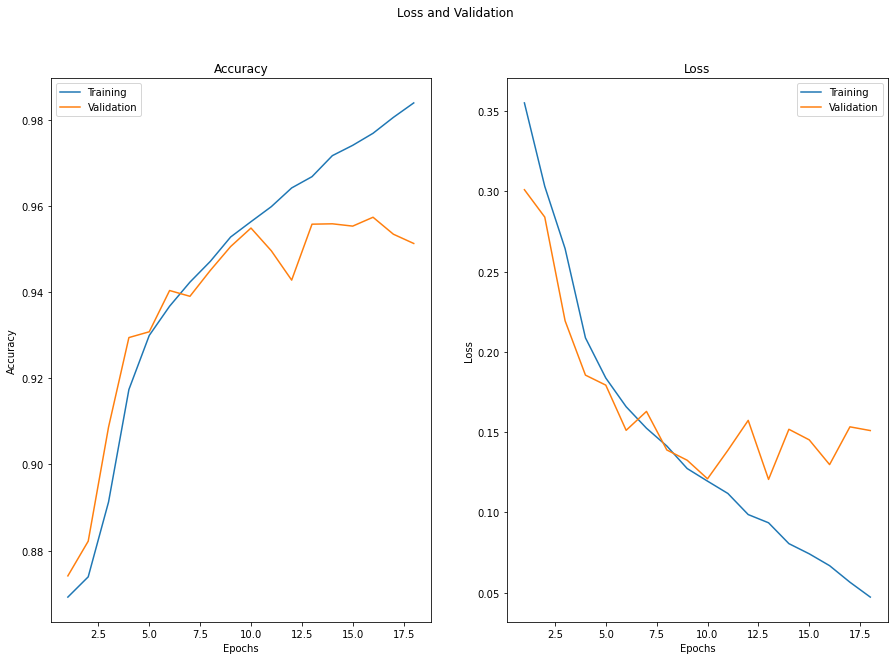

In [16]:
reset_keras()
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Loss and Validation")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

# Metrics

In [17]:
y_pred_prb=model.predict(x_test)
y_pred=np.round(model.predict(x_test),0)
target=["Negative","Positive"] 
cm=metrics.confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),3))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred),3))
print('Specificity', np.round(cm[0,0]/(cm[0,0]+cm[0,1]),3))
print(metrics.classification_report(y_test, y_pred,target_names=target))

[[13113   247]
 [  401  1603]]
Accuracy: 0.958
F1 Score: 0.832
Specificity 0.982
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.98     13360
    Positive       0.87      0.80      0.83      2004

    accuracy                           0.96     15364
   macro avg       0.92      0.89      0.90     15364
weighted avg       0.96      0.96      0.96     15364



# Function to Paint Anomalies based on Single Layer

In [18]:
import scipy as sp
gc.collect()
reset_keras()

pos=[2,13,25,26,38, 42, 44]

partial=x_test[pos,:,:,:]
intermediate = Model(model.input,model.get_layer("block5_conv3").output) #get bottom layer and use as model
conv_output = intermediate.predict(partial)   #get the testing output
conv_output = np.squeeze(conv_output) #Remove unnecessary layer
weights = np.squeeze(model.layers[-1].get_weights()[0])  #get the weights

def myplot(img):    
    conv_output2 = conv_output[img] #get the prediction
    r = int(size/conv_output2.shape[0]) #multiplying ratio for mapping
    act_maps = sp.ndimage.zoom(conv_output2, (r,r, 1), order=1)
    act_maps=act_maps.reshape((size*size,intermediate.output.shape[3]))
    out = act_maps@weights
    out=out
    out=out.reshape(size,size)/255
    return(out)


# View Features from One Layer

C:\Users\tf\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


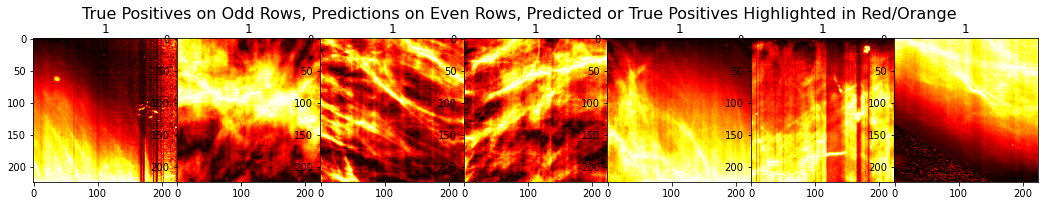

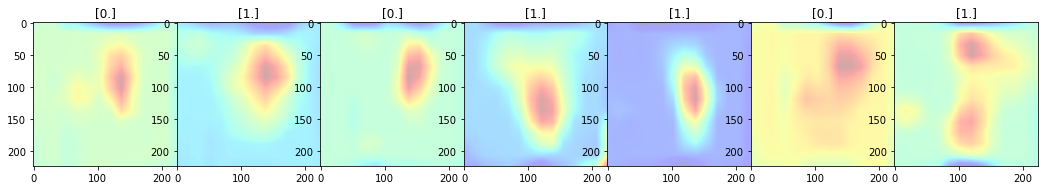

In [19]:
numim=7
   
fig, ax = plt.subplots(1,numim, figsize=[18, 3])
fig2, ax2 = plt.subplots(1,numim, figsize=[18, 3])
fig.suptitle('True Positives on Odd Rows, Predictions on Even Rows, Predicted or True Positives Highlighted in Red/Orange', fontsize=16)

zeros=np.zeros((size,size))

x=0
for i in pos:
    val=y_test[i]
    ax[x].imshow(x_train[i, :,:,0],'hot') 
    ax[x].set_title(y_test[i])
    fig.subplots_adjust(wspace=0, hspace=0)
    x+=1
x=0
for i in pos:
    val=y_test[i]
    temp=myplot(x)
    #temp=myscaler.fit_transform(temp)
    ax2[x].imshow(temp, 'jet', alpha=.35)
    fortit=np.round(y_pred[i],0)
    ax2[x].set_title(fortit)
    fig2.subplots_adjust(wspace=0, hspace=0)
    x+=1
         

# Paint Convolutional Layer Images

In [20]:
layer_names = [layer.name for layer in model.layers] #get the names
u=18 #number of layers I will select
layer_names = [layer.name for layer in model.layers[1:u]] #get the names
layer_outputs = [layer.output for layer in model.layers[1:u]] #get the outputs
print(layer_names)

['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


# Get Important Layer Outputs

In [21]:
feature_map_model = Model(model.input, layer_outputs) #build the models
feature_maps = feature_map_model.predict(partial) #predict the features

# Get the Images into an Array

In [22]:
image_belt=[]
for layer_name, feature_map in zip(layer_names, feature_maps):  
    for i in range(numim):
        feature_image = feature_map[i, :, :, 0]
        h = int(size/feature_image.shape[0]) #multiplying ratios for mapping
        feature_image = sp.ndimage.zoom(feature_image, (h, h), order=1)
        feature_image=feature_image/255
        image_belt.append(feature_image)
image_belt=np.asarray(image_belt)
print(image_belt.shape)


(119, 224, 224)


# Paint the Layer Representation of the Image

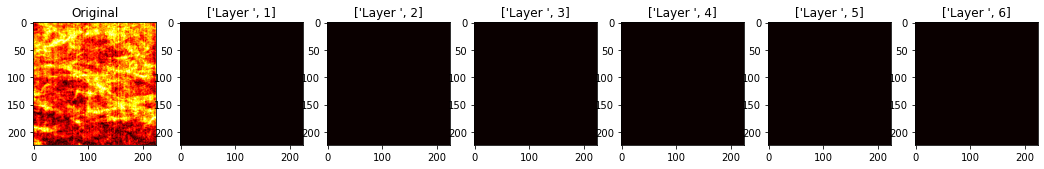

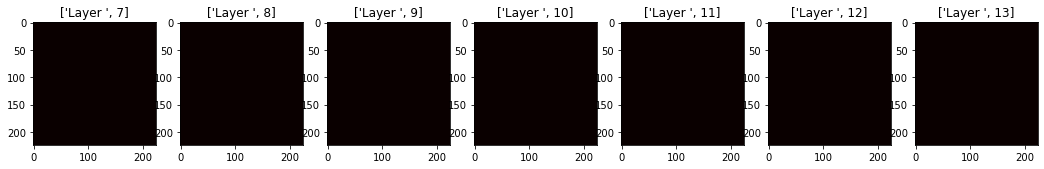

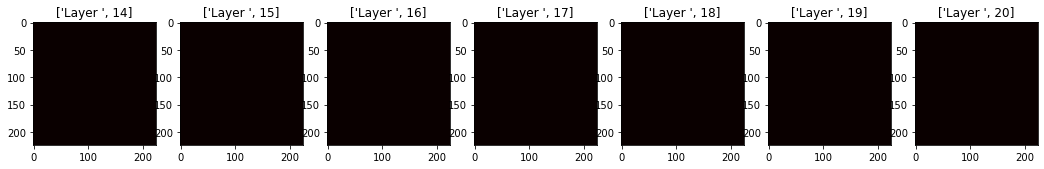

In [23]:
im=7 #number of images per line
imnum=0 #17 layers, 0 to 16....image 0 starts at 0 ends at 16; image 1 starts at 17, image 2 starts at 30
begin=imnum*17-17

fig, ax = plt.subplots(1,im, figsize=[18, 3])
fig2, ax2 = plt.subplots(1,im, figsize=[18, 3])
fig3, ax3 = plt.subplots(1,im, figsize=[18, 3])

ax[0].imshow(x_test[imnum, :,:,0],cmap='hot') 
ax[0].set_title('Original')
for i in np.arange(1,im):
    ax[i].imshow(image_belt[begin-1+i],cmap='hot')   #map for 6 other layers
    t=['Layer ',i]
    ax[i].set_title(t)
for i in np.arange(0,im):
    ax2[i].imshow(image_belt[begin+i],cmap='hot')  #map for 
    t=['Layer ',i+7]
    ax2[i].set_title(t)
for i in np.arange(0,im):
    ax3[i].imshow(image_belt[begin+i],cmap='hot')
    t=['Layer ',i+14]
    ax3[i].set_title(t)


## Get the Gradient of the Score with respect to the Image Layer

In [24]:
def watch_layer(layer, tape):
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Store the result of `layer.call` internally.
            layer.result = func(*args, **kwargs)
            # From this point onwards, watch this tensor.
            tape.watch(layer.result)
            # Return the result to continue with the forward pass.
            return layer.result
        return wrapper
    layer.call = decorator(layer.call)
    return layer

bx = tf.reshape(x_test[0, :, :, :], (1, size,size, 3))
last_conv_layer = model.get_layer('block5_conv3')
with tf.GradientTape() as gtape:
    watch_layer(last_conv_layer, gtape)  
    preds = model(partial)
    grads=gtape.gradient(preds, last_conv_layer.result)

# Get the gradient w.r.t. the output of `last_conv_layer`
grads.shape


TensorShape([7, 14, 14, 512])

## Get the Neuron Activations

In [25]:
myneurons=conv_output

## Get Highest Active Neurons Based on Gradient wrt Loss

In [26]:
plotnum=pos
rank=myneurons

# Select Subset of Neurons Based on Rank

In [27]:
final=[]
x=[]
y=[]
ct=0
for plots in plotnum:
    conv_output2=conv_output[0]
    r = int(size/conv_output2.shape[0])
    tmp=sp.ndimage.zoom(myneurons[ct], (r,r, 1), order=1)
    tmp.shape
    tmp=tmp.reshape((size*size,512))
    tmp=tmp@weights
    tmp=tmp.reshape(size,size)
    tmp=myscaler.fit_transform(tmp)
    #tmp=abs(tmp)
    final.append(tmp)    
    t1=np.argmax(np.max(abs(tmp), axis=0))
    x.append(t1)
    t2=np.argmax(np.max(abs(tmp), axis=1))
    y.append(t2)
    ct+=1


# Plot and Identify Activation Area

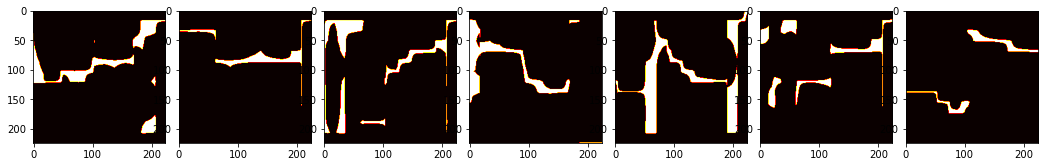

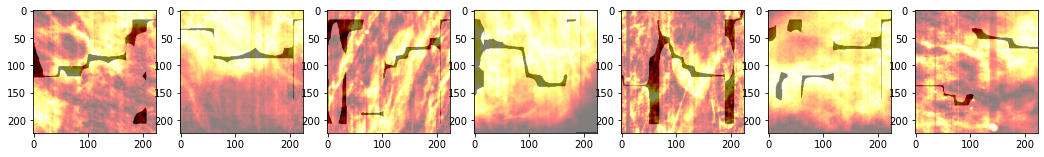

In [29]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1,7, figsize=[18, 3])
fig1,ax1=plt.subplots(1,7, figsize=[18, 3])


for i in range(7):
    mask=np.zeros((size,size))
    mask[final[i]>np.quantile(final[0],.92)]=1
    ax[i].imshow(mask, cmap='hot') 
for i in range(7):
    mask=np.zeros((size,size))
    mask[final[i]>np.quantile(final[0],.92)]=1
    imnum=plotnum[i]
    ax1[i].imshow(x_test[imnum,:,:,0], cmap='hot') 
    ax1[i].imshow(mask, cmap='Greys', alpha=.5)
    
fig.subplots_adjust(wspace=.1, hspace=.1)